<a href="https://colab.research.google.com/github/DouglasTannus/MVP_PUC-Rio_Machine-Learning_09-2025/blob/main/MVP_Machine_Learning_PUC_Rio_09_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MVP: Machine Learning & Analytics**

Autor: Douglas Tannus

Data: 28/09/2025

Matrícula: 4052025001295

Dataset: [Indian Liver Patient Dataset](https://raw.githubusercontent.com/DouglasTannus/MVP_PUC-Rio_Machine-Learning_09-2025/refs/heads/main/Indian%20Liver%20Patient%20Dataset%20(ILPD).csv)



# 1. CONTEXTO E DEFINIÇÃO DO OBJETIVO

A mortalidade por cirrose hepática continua a aumentar, devido ao aumento das taxas de consumo de álcool, infecções por hepatite crônica e doenças hepáticas relacionadas à obesidade.

Apesar da alta mortalidade por essa doença, as doenças hepáticas não afetam todas a população igualmente. A detecção precoce da patologia é um determinante dos desfechos dos pacientes, mas os pacientes do sexo feminino parecem ser marginalizadas quando se trata do diagnóstico precoce de patologia hepática.

O dataset possui 584 registros de pacientes coletados em Andhra Pradesh, Índia. A tarefa de predição consiste em determinar se um paciente sofre de doença hepática com base em informações sobre vários marcadores bioquímicos, incluindo albumina e outras enzimas necessárias para o metabolismo.

O resultado "1" no target indica presença de doença hepática e o resultado "2" no target indica sua ausência.

# 2. AMBIENTE E REPRODUTIBILIDADE

In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

# Definição de seed fixa
seed = 21
np.random.seed(seed)

# 3. CARGA DO DATASET E VERIFICAÇÕES INICIAIS

In [2]:
url = "https://raw.githubusercontent.com/DouglasTannus/MVP_PUC-Rio_Machine-Learning_09-2025/refs/heads/main/Indian%20Liver%20Patient%20Dataset%20(ILPD).csv"

dataset = pd.read_csv(url, delimiter=',')

dataset.head()

,Age,Gender,Total Bilirubin,Direct Bilirubin,Alkaline Phosphotase,Alamine Aminotransferase,Aspartate Aminotransferase,Total Proteins,Albumin,Albumin and Globulin Ratio,Target
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


# 4. TRATAMENTO E TRANSFORMAÇÃO

In [3]:
# Convertendo a coluna 'Gender' para numérica usando one-hot encoding
dataset = pd.get_dummies(dataset, columns=['Gender'], drop_first=True)

# Reordenando as colunas para mover 'Gender_Male'
cols = dataset.columns.tolist()
cols.insert(1, cols.pop(cols.index('Gender_Male')))
dataset = dataset[cols]

# Criando um imputer para substituir valores ausentes pela média
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Aplicando o imputer ao dataset
dataset_imputed = imputer.fit_transform(dataset)

# Convertendo o resultado de volta para um DataFrame
dataset_imputed = pd.DataFrame(dataset_imputed, columns=dataset.columns)

dataset.head()

,Age,Gender_Male,Total Bilirubin,Direct Bilirubin,Alkaline Phosphotase,Alamine Aminotransferase,Aspartate Aminotransferase,Total Proteins,Albumin,Albumin and Globulin Ratio,Target
0,65,False,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,True,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,True,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,True,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,True,3.9,2.0,195,27,59,7.3,2.4,0.40,1


# 5. ESTRATIFICAÇÃO E DEFINIÇÃO DE MÉTRICA DE AVALIAÇÃO

In [4]:
test_size = 0.30 # definição do tamanho do conjunto de teste

# Atualizando o array com os dados imputados
array = dataset_imputed.values
X = array[:,0:10] # atributos
y = array[:,10] # classe (target)

# Separação em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Convertendo y_train e y_test para inteiros
y_train = y_train.astype('int')
y_test = y_test.astype('int')

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

# 6. MODELOS, PARÂMETROS E RESULTADOS INICIAIS

LR: 0.715915 (0.055896)
KNN: 0.688841 (0.053149)
CART: 0.735183 (0.051487)
NB: 0.551646 (0.076603)
SVM: 0.713293 (0.009291)
Bagging: 0.740366 (0.047197)
RF: 0.728171 (0.055620)
ET: 0.715915 (0.057985)
Ada: 0.718232 (0.059638)
GB: 0.725610 (0.050521)
Voting: 0.720732 (0.038641)


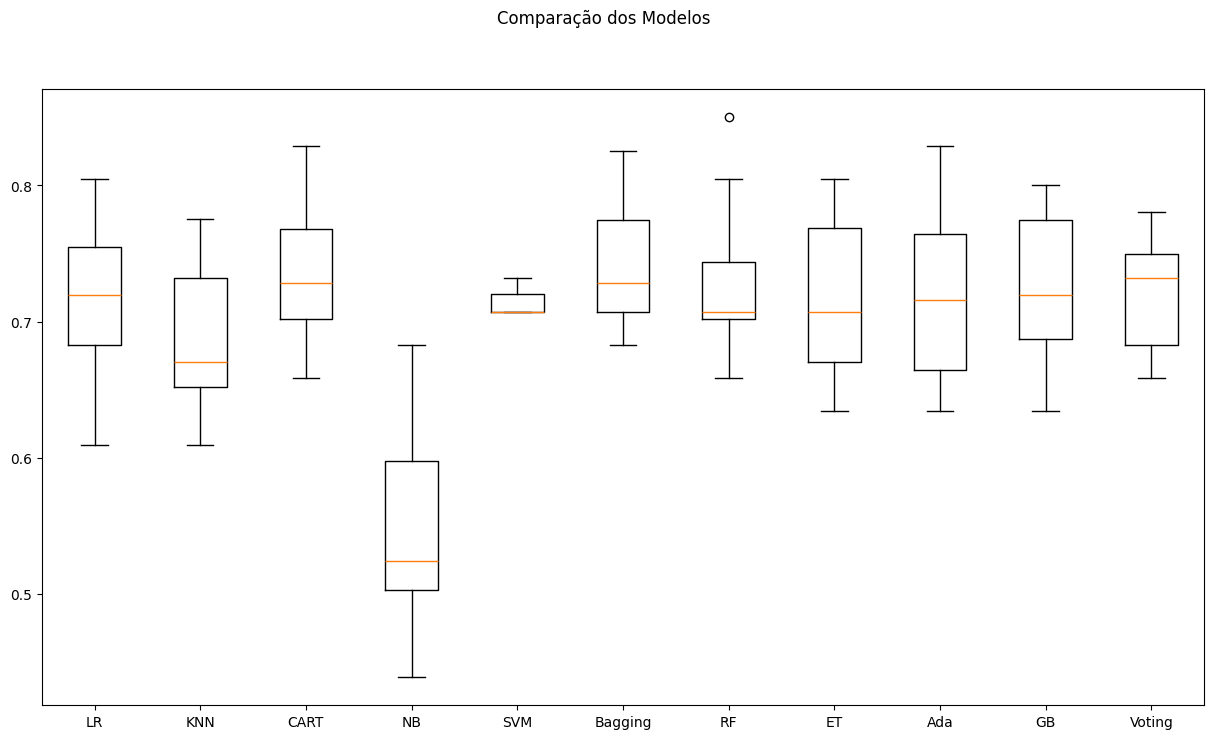

In [5]:
# Lista que armazenará os modelos
modelos = []

# Convertendo y_train e y_test para inteiros
y_train = y_train.astype('int')
y_test = y_test.astype('int')

# Adicionando os modelos
modelos.append(('LR', LogisticRegression(max_iter=200)))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('CART', DecisionTreeClassifier()))
modelos.append(('NB', GaussianNB()))
modelos.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier e outros ensembles
base = DecisionTreeClassifier()
num_trees = 300
max_features = 5

# Criando os modelos para o VotingClassifier
bases = []
modelo1 = KNeighborsClassifier()
bases.append(('knn', modelo1))
modelo2 = SVC()
bases.append(('svm', modelo2))
modelo3 = LogisticRegression(max_iter=200)
bases.append(('logistic', modelo3))


# Adicionando os ensembles na lista
modelos.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
modelos.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
modelos.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
modelos.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
modelos.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
modelos.append(('Voting', VotingClassifier(bases)))


# Listas para armazenar os resultados
resultados = []
nomes = []

# Avaliação dos modelos
for name, model in modelos:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    resultados.append(cv_results)
    nomes.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

# RESULTADOS NO DATASET ORIGINAL, PADRONIZADO E NORMALIZADO


LR-OG: 0.716 (0.056)
KNN-OG: 0.689 (0.053)
CART-OG: 0.735 (0.051)
NB-OG: 0.552 (0.077)
SVM-OG: 0.713 (0.009)
Bag-OG: 0.725 (0.041)
RF-OG: 0.721 (0.054)
ET-OG: 0.723 (0.063)
Ada-OG: 0.706 (0.049)
GB-OG: 0.714 (0.065)
Vot-OG: 0.721 (0.039)
LR-PD: 0.718 (0.059)
KNN-PD: 0.691 (0.072)
CART-PD: 0.708 (0.071)
NB-PD: 0.552 (0.077)
SVM-PD: 0.694 (0.060)
Bag-PD: 0.721 (0.063)
RF-PD: 0.723 (0.050)
ET-PD: 0.716 (0.062)
Ada-PD: 0.706 (0.049)
GB-PD: 0.716 (0.065)
Vot-PD: 0.726 (0.060)
LR-NL: 0.713 (0.018)
KNN-NL: 0.667 (0.078)
CART-NL: 0.725 (0.051)
NB-NL: 0.552 (0.077)
SVM-NL: 0.713 (0.009)
Bag-NL: 0.738 (0.054)
RF-NL: 0.728 (0.053)
ET-NL: 0.716 (0.051)
Ada-NL: 0.706 (0.049)
GB-NL: 0.706 (0.066)
Vot-NL: 0.713 (0.018)


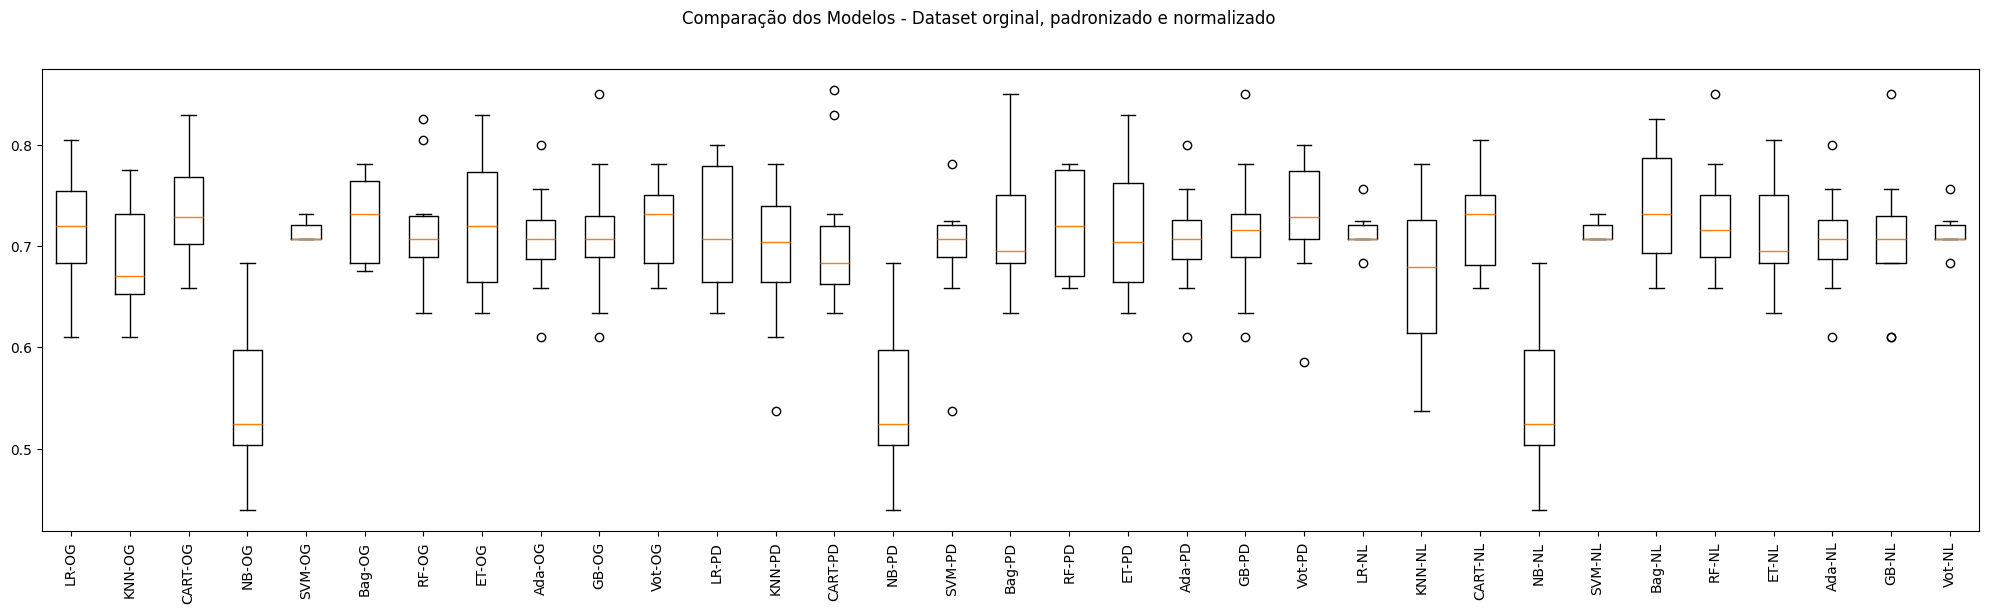

In [ ]:
# Listas para armazenar os pipelines e os resultados para todos os datasets
pipelines = []
resultados = []
nomes = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
log_r = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_b = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_f = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_t = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_b = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-OG', Pipeline([log_r])))
pipelines.append(('KNN-OG', Pipeline([knn])))
pipelines.append(('CART-OG', Pipeline([cart])))
pipelines.append(('NB-OG', Pipeline([naive_b])))
pipelines.append(('SVM-OG', Pipeline([svm])))
pipelines.append(('Bag-OG', Pipeline([bagging])))
pipelines.append(('RF-OG', Pipeline([random_f])))
pipelines.append(('ET-OG', Pipeline([extra_t])))
pipelines.append(('Ada-OG', Pipeline([adaboost])))
pipelines.append(('GB-OG', Pipeline([gradient_b])))
pipelines.append(('Vot-OG', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-PD', Pipeline([standard_scaler, log_r])))
pipelines.append(('KNN-PD', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-PD', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-PD', Pipeline([standard_scaler, naive_b])))
pipelines.append(('SVM-PD', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-PD', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-PD', Pipeline([standard_scaler, random_f])))
pipelines.append(('ET-PD', Pipeline([standard_scaler, extra_t])))
pipelines.append(('Ada-PD', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-PD', Pipeline([standard_scaler, gradient_b])))
pipelines.append(('Vot-PD', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-NL', Pipeline([min_max_scaler, log_r])))
pipelines.append(('KNN-NL', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-NL', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-NL', Pipeline([min_max_scaler, naive_b])))
pipelines.append(('SVM-NL', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-NL', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-NL', Pipeline([min_max_scaler, random_f])))
pipelines.append(('ET-NL', Pipeline([min_max_scaler, extra_t])))
pipelines.append(('Ada-NL', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-NL', Pipeline([min_max_scaler, gradient_b])))
pipelines.append(('Vot-NL', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    resultados.append(cv_results)
    nomes.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes, rotation=90)
plt.show()



# OTIMIZAÇÃO DE HIPERPARÂMETROS E RESULTADOS COM O MODELO ESCOLHIDO

In [ ]:
# Otimização dos hiperparâmetros de Bagging

np.random.seed(21)

pipelines = []

# Definindo os componentes do pipeline
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('bag-OG', Pipeline(steps=[bagging])))
pipelines.append(('bag-PD', Pipeline(steps=[standard_scaler, bagging])))
pipelines.append(('bag-NL', Pipeline(steps=[min_max_scaler, bagging])))

param_grid = {
    'Bag__n_estimators': [100, 200, 300, 400, 500],
    'Bag__max_features': [5, 6, 7, 8, 9]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: bag-OG - Melhor: 0.742927 usando {'Bag__max_features': 8, 'Bag__n_estimators': 500}
Sem tratamento de missings: bag-PD - Melhor: 0.742866 usando {'Bag__max_features': 8, 'Bag__n_estimators': 300}
Sem tratamento de missings: bag-NL - Melhor: 0.740488 usando {'Bag__max_features': 9, 'Bag__n_estimators': 400}


# AVALIAÇÃO DO MODELO COM O CONJUNTO DE TESTES E HIPERPARÂMETROS OTIMIZADOS

In [ ]:
# Preparação do modelo com hiperparâmetros otimizados no dataset original
model = BaggingClassifier(estimator=base, n_estimators=500, max_features=8)
model.fit(X_train, y_train)

# Estimativa da acurácia no conjunto de teste
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))

0.6857142857142857


# PREPARAÇÃO DO MODELO COM TODO O DATASET

In [ ]:
# Preparação do modelo com TODO o dataset
model.fit(X, y)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_features=8,
                  n_estimators=500)

# INSERÇÃO DE NOVOS FEATURES PARA PREDIÇÃO DOS TARGETS

In [ ]:
# Inserção de novos dados
data = {'Age':  [34, 21, 48, 62],
        'Gender': [True, False, False, True],
        'TB': [1.8, 1.2, 12.8, 7.4],
        'DB': [0.7, 0.3, 8.0, 3.9],
        'Alkphos': [180, 165, 368, 508],
        'Alaamino': [18, 24, 45, 72],
        'Aspamino': [28, 18, 85, 74],
        'TP': [6.2, 6.4, 5.1, 7.2],
        'ALB': [3.4, 3.3, 2.2, 3.6],
        'A/G Ratio':[0.94, 0.98, 0.82, 0.99]
        }

atributos = ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'Alaamino', 'Aspamino', 'TP', 'ALB', 'A/G Ratio']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:10]


print(X_entrada)

[[34 True 1.8 0.7 180 18 28 6.2 3.4 0.94]
 [21 False 1.2 0.3 165 24 18 6.4 3.3 0.98]
 [48 False 12.8 8.0 368 45 85 5.1 2.2 0.82]
 [62 True 7.4 3.9 508 72 74 7.2 3.6 0.99]]


# PREDIÇÃO DAS CLASSES COM OS NOVOS DADOS INSERIDOS

In [ ]:
# Predição dos targets com os novos dados inseridos
saidas = model.predict(X_entrada)
print(saidas)

[1. 2. 1. 1.]
